# postKinectのサンプルプログラム

## 実行環境
anaconda 2020.11をインストール後，下記モジュールをインストールし，JupyterLabを起動する．
```
pip install pyvista

pip install opencv-python
pip install opencv-contrib-python

conda install nodejs
pip install itkwidgets
jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-matplotlib jupyterlab-datawidgets itkwidgets
pip install ipywidgets

jupyter labextension install @jupyter-widgets/jupyterlab-manager
jupyter nbextension enable --py --sys-prefix widgetsnbextension

pip install tqdm
```

In [1]:
import numpy as np
import pyvista as pv
import cv2
import matplotlib.pyplot as plt
import ipywidgets as widgets

import sys, os
from pathlib import Path
#現在の絶対パスを取得
current_dir = Path().resolve()
sys.path.append(str(current_dir) + '/../../')

import postBase
import postCore

## ファイルの読込
- マッピングファイル
- デプスデータファイル
- dsの構造: frameの数(150), 時間(150の配列), \[150×424×512\](150フレームの424×512に対応する深さデータ)

In [2]:
mapTableFName = '../../mapTable_depth_to_3D.dat'
#mappingtableの読み込み
mt = postBase.readMapTable(mapTableFName)
#casedirと同じフォルダ
#背景画像(対象物が移ってないもの)
caseDir_background = '2021-0603-164246_init'
#対象画像
caseDir = '2021-0603-180802_15ms-2' # 10 m/s
#caseDir = '2019-1028-132232' # 12 m/s
#caseDir = '2019-1028-132314' # 14 m/s
#caseDir = '2019-1028-132501' # 16 m/s
#caseDir = '2019-1028-132552' # 18 m/s
#caseDir = '2019-1028-132743' # 20 m/s
#caseDir = '2019-1028-132920' # 18 m/s
#caseDir = '2019-1028-133150' # 16 m/s
#caseDir = '2019-1028-133342' # 14 m/s
#caseDir = '2019-1028-133543' # 12 m/s
#caseDir = '2019-1028-133713' # 10 m/s
#caseDir = '2019-1028-133839' # 10 m/s
#caseDir = '2019-1028-134040' # 10 m/s
#caseDir = '2019-1028-134235' # 10 m/s
#caseDir_background = '2019-1028-134457'
ds_back = postBase.readDepthLogs(caseDir_background)
#nFrame, depthCounts, depthBuffersが返ってくる
ds = postBase.readDepthLogs(caseDir)

 [Info] reading ... : ../../mapTable_depth_to_3D.dat
 [Info] reading ... : 2021-0603-164246_init/depth\depth_00003.dat
   Total Frame : 150
 [Info] reading ... : 2021-0603-180802_15ms-2/depth\depth_00000.dat
   Total Frame : 150


## Bilateralフィルターの適用
- ds_BF:バイラテラルフィルタ適用
- ds:対象物
- ds_back: 背景画像
- ds_front: 背景画像を減算したもの

In [3]:
from tqdm import tqdm

fileName_ds_BF = '/ds_BF.npz'
filePath = caseDir+fileName_ds_BF
if not os.path.exists(filePath):
    ds_BF = []
    #tqdm プログレスバーを表示させる
    for d in tqdm(ds[2]):
        d_BF = postBase.bilateralFilter0(d.astype(np.float32), 5, 5.0, 100.0)
        ds_BF.append(d_BF)
    ds_BF = np.array(ds_BF)
    #npzファイルの生成
    np.savez_compressed(filePath, ds_BF=ds_BF)
else:
    ds_BF = np.load(filePath)['ds_BF']


## ローパスフィルターの適用

In [4]:
'''
fileName_ds_BF_LPF = '/ds_BF_LPF.npy'
if not os.path.exists(caseDir+fileName_ds_BF_LPF):
    ds_BF_LPF = postBase.calcLowpassFilter2(np.array(ds_BF))
    np.save(caseDir+fileName_ds_BF_LPF, ds_BF_LPF)
else:
    ds_BF_LPF = np.load(caseDir+fileName_ds_BF_LPF)
'''
ds[2].shape

(150, 424, 512)

In [5]:
depths = {}
#時間方向
depths['ts'] = ds[1]
#depths['ds_BF_LPF'] = ds_BF_LPF
depths['ds_BF'] = ds_BF
depths['ds'] = ds[2]
depths['ds_back'] = ds_back[2]

nFrame, depthHeight, depthWidth = ds[2].shape

@widgets.interact(i_pixel=(0, depthWidth-1, 1), j_pixel=(0, depthHeight-1, 1))
def plotTimeHistory(i_pixel, j_pixel):
    plt.plot(depths['ts'], depths['ds_BF'][:,j_pixel,i_pixel])
    #plt.plot(depths['ts'], depths['ds_BF_LPF'][:,j_pixel,i_pixel])
    #plt.plot(depths['ts'], depths['ds_back'][:,j_pixel,i_pixel])
    plt.show()
    
    fig, ax = plt.subplots()
    ax.imshow(depths['ds'][0], cmap='gray_r')
    ax.scatter([i_pixel], [j_pixel])
    ax.invert_xaxis()
    plt.show()   

interactive(children=(IntSlider(value=255, description='i_pixel', max=511), IntSlider(value=211, description='…

## デプス画像の表示

In [6]:
depths = {}
#depths['ds_BF_LPF'] = ds_BF_LPF
depths['ds_BF'] = ds_BF
depths['ds'] = ds[2]
depths['ds_back'] = ds_back[2]

@widgets.interact(key=depths.keys(), nFrame=(0, ds[0]-1, 1))
def showDepthImageGray(key, nFrame=0):
    #img = postBase.createDepthImageGray(depths[key][nFrame])
    #plt.imshow(img, cmap = 'gray')
    plt.imshow(cv2.flip(depths[key][nFrame], 1), cmap='gray_r')
    plt.colorbar()
    plt.show()

@widgets.interact(key=depths.keys(), nFrame=(0, ds[0]-1, 1))
def showDepthImage(key, nFrame=0):
    #img = postBase.createDepthImage(depths[key][nFrame])
    #plt.imshow(img)
    plt.imshow(cv2.flip(depths[key][nFrame], 1), cmap = 'rainbow')
    plt.colorbar()
    plt.show()
    

interactive(children=(Dropdown(description='key', options=('ds_BF', 'ds', 'ds_back'), value='ds_BF'), IntSlide…

interactive(children=(Dropdown(description='key', options=('ds_BF', 'ds', 'ds_back'), value='ds_BF'), IntSlide…

## デプスの平均値と標準偏差

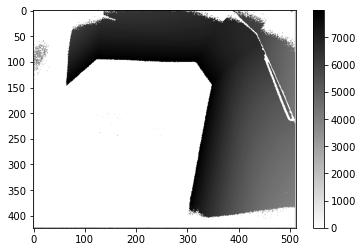

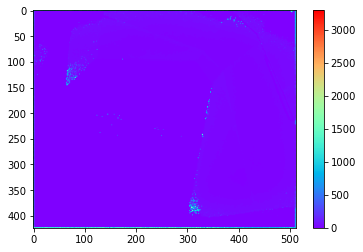

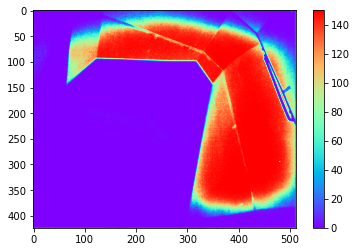

In [7]:
#壁面データ
#平均，標準偏差,nullの数
ds_back_mean, ds_back_std, count_nonzero_back = postBase.calcMeanStd(ds_back[2])

plt.imshow(cv2.flip(ds_back_mean, 1), cmap='gray_r')
plt.colorbar()
plt.show()

plt.imshow(cv2.flip(ds_back_std, 1), cmap='rainbow')
plt.colorbar()
plt.show()

plt.imshow(cv2.flip(count_nonzero_back, 1), cmap='rainbow')
plt.colorbar()
plt.show()

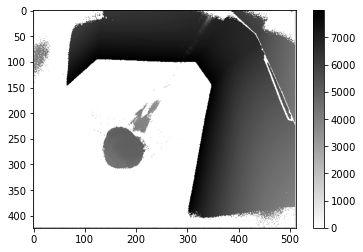

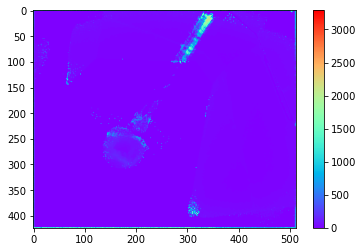

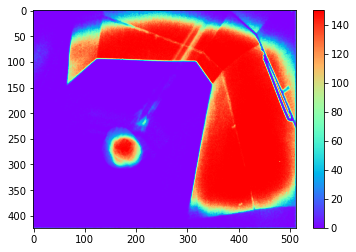

In [8]:
#対象データ
ds_mean, ds_std, count_nonzero = postBase.calcMeanStd(ds[2])

plt.imshow(cv2.flip(ds_mean, 1), cmap='gray_r')
plt.colorbar()
plt.show()

plt.imshow(cv2.flip(ds_std, 1), cmap='rainbow')
plt.colorbar()
plt.show()

plt.imshow(cv2.flip(count_nonzero, 1), cmap='rainbow')
plt.colorbar()
plt.show()

## 背景画像からの減算による物体抽出

In [9]:
ds_back_mean, ds_back_std, count_nonzero_back = postBase.calcMeanStd(ds_back[2])

fileName_ds_front = '/ds_front.npz'
filePath = caseDir+fileName_ds_front
if not os.path.exists(filePath):
    #背景画像の減算処理
    ds_front = [postBase.calcFrontground(d, ds_back_mean, threshold=5000) for d in ds[2]]
    ds_front = np.array(ds_front)
    np.savez_compressed(filePath, ds_front=ds_front)
else:
    ds_front = np.load(filePath)['ds_front']
# ds_front = [postBase.calcFrontground(d, ds_back_mean, threshold_depth=4400) for d in ds[2]]

fileName_ds_BF_front = '/ds_BF_front.npz'
filePath = caseDir+fileName_ds_BF_front
if not os.path.exists(filePath):
    ds_BF_front = [postBase.calcFrontground(d, ds_back_mean, threshold_depth=5000) for d in ds_BF]
    ds_BF_front = np.array(ds_front)
    np.savez_compressed(filePath, ds_BF_front=ds_BF_front)
else:
    ds_BF_front = np.load(filePath)['ds_BF_front']


In [10]:
depths = {}
depths['ds_front'] = ds_front
depths['ds'] = ds[2]
depths['ds_back'] = ds_back[2]
depths['ds_BF_front'] = ds_BF_front
depths['ds_BF'] = ds_BF

@widgets.interact(key=depths.keys(), nFrame=(0, ds[0]-1, 1))
def showDepthImage(key, nFrame=0):
    plt.imshow(cv2.flip(depths[key][nFrame], 1), cmap = 'gray_r')
    plt.colorbar()
    plt.show()

interactive(children=(Dropdown(description='key', options=('ds_front', 'ds', 'ds_back', 'ds_BF_front', 'ds_BF'…

## デプスからXYZ直交座標系への変換

In [11]:
nFrame = 0
xyz0s = postBase.convDepth2XYZ(mt, ds[2][nFrame])
# xyz0s = postBase.convDepth2XYZ(mt, ds_front[2][nFrame])
np.shape(xyz0s)

(424, 512, 3)

In [12]:
#mt sin cosを格納しているファイル
mt.shape

(2, 424, 512)

In [13]:
xyzs = np.array([xyz for xyz in xyz0s.reshape((-1,3)) if xyz[2] != 0])
point_cloud = pv.PolyData(xyzs)
display(point_cloud)

PolyData,Information
N Cells,77973
N Points,77973
X Bounds,"-5.702e+00, 5.640e+00"
Y Bounds,"-4.715e+00, 4.649e+00"
Z Bounds,"5.210e-01, 7.999e+00"
N Arrays,0


In [14]:
pl = pv.PlotterITK()
pl.add_mesh(point_cloud, scalars=np.array(xyzs[:,2]), smooth_shading=True)
#pl.add_mesh(point_cloud)
pl.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [15]:
# xyz0s = postBase.convDepth2XYZ(mt, ds_BF[0])
#front：本体のみ
xyz0s = postBase.convDepth2XYZ(mt, ds_front[0])
# xyz0s = postBase.convDepth2XYZ(mt, ds_mean)
# xyz0s = postBase.convDepth2XYZ(mt, ds[1])
# xyz0s = postBase.convDepth2XYZ(mt, ds_back_mean)
xyzs = np.array([xyz for xyz in xyz0s.reshape((-1,3)) if xyz[2] != 0])
point_cloud = pv.PolyData(xyzs)
display(point_cloud)

pl = pv.PlotterITK()
pl.add_mesh(point_cloud, scalars=np.array(xyzs[:,2]), smooth_shading=True)
#pl.add_mesh(point_cloud)
pl.show(True)

PolyData,Information
N Cells,2809
N Points,2809
X Bounds,"-5.015e+00, 4.945e+00"
Y Bounds,"-4.715e+00, 4.415e+00"
Z Bounds,"6.260e-01, 7.998e+00"
N Arrays,0


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## 背景画像から風洞座標系への変換行列を算出

### 風洞側壁に該当する点群の抽出

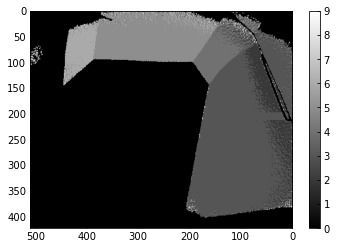

[0 2 3 4 5 6 7 8 9]
41498
5176
17858
4447
[0 1 2 3 4]


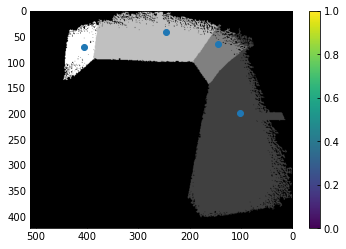

In [71]:
xyz_back_mean = postBase.convDepth2XYZ(mt, ds_back_mean)
nv_mean = postBase.calcNormal(xyz_back_mean)

arctan_mean = postBase.calcArctan(nv_mean) + 22.5*np.pi/180.0
arctan_mean = postBase.calcMinMaxScaling(arctan_mean, 9).astype('uint8')
fig, ax = plt.subplots()
plt.imshow(arctan_mean, cmap='gray')
ax.invert_xaxis()
plt.colorbar()
plt.show()

seedList = [
      [3, 101, 199]
    , [4, 144, 64]
    , [5, 245, 41]
    , [6, 406, 69]
#     , [7, 441, 199]
]

h, w = arctan_mean.shape[:2]
mask0 = np.zeros((h + 2, w + 2), dtype='uint8')
mask0[1:-1,1:-1] = arctan_mean
print(np.unique(mask0))
markers = np.zeros_like(arctan_mean, dtype='uint8')
for n, [val, i, j] in enumerate(seedList):
    mask = np.where(mask0 == val, 0, 1).astype('uint8')
    #markers:塗りつぶされた後の画像．なおここではmarkers配列に対してseed値で渡された値の領域を蓄積している
    #mask:塗りつぶしのみの画像
    retval, markers, mask, rect = cv2.floodFill(markers, mask, seedPoint=(i, j), newVal=n+1)
    print(retval)
print(np.unique(markers))


fig, ax = plt.subplots()
plt.imshow(markers, cmap='gray')
plt.scatter([s[1] for s in seedList], [s[2] for s in seedList])
ax.invert_xaxis()
plt.colorbar()
plt.show()

In [72]:
mask0.shape
markers.shape
print(np.unique(markers))

[0 1 2 3 4]


### 側壁に該当する点群に対して，最小自乗法による平面の算出

In [73]:
param_plane = []
vec_plane = []
xyz_plane = []
for n in range(len(seedList)):
    d = np.where(markers == n+1, ds_back_mean, 0)
    #非ゼロの要素の大きさを取得
    count = d[d.nonzero()].size
    print('%d : count=%d' % (n, count))
    if count == 0:
        param_plane.append([])
        vec_plane.append([])
        xyz_plane.append([])
        continue
    #print(d[d.nonzero()])
    #base.writeXYZ(dirName0+'/plane_%02d.xyz' % (n), d, mapperTable)
    xyz = postBase.convDepth2XYZ(mt, d)
    xyz = xyz[xyz.nonzero()]
    xyz = xyz.reshape(xyz.size//3, 3)
    vec_normal, param = postBase.calcPlane(xyz, showFlag=False)
    param_plane.append(param)
    vec_plane.append(vec_normal)
    xyz_plane.append(xyz)


0 : count=41498
mean=9.766581e-16, std=0.384172, count=41498
[ 0.91603635  0.23505666 -0.32500119  4.269678  ]
mean=-2.545298e-10, std=0.214185, count=28747
[ 0.91892307  0.23497347 -0.31680888  4.21196612]
mean=-5.062727e-10, std=0.122214, count=17784
[ 0.92023721  0.23571376 -0.31241399  4.1827226 ]
mean=-6.163184e-10, std=0.070038, count=10634
[ 0.92073844  0.23620418 -0.31056128  4.17050918]
mean=-1.290491e-15, std=0.039998, count=6208
[ 0.92092886  0.23640384 -0.30984393  4.16597652]
1 : count=5176
mean=-1.475909e-09, std=0.148619, count=5176
[-0.54329406  0.41978853  0.72705512 -7.45539297]
mean=-1.087902e-15, std=0.082927, count=3442
[-0.53852852  0.44098414  0.71799723 -7.42179781]
mean=-1.131330e-15, std=0.046670, count=2104
[-0.53454031  0.44933167  0.71579865 -7.41436929]
2 : count=17858
mean=8.637983e-10, std=0.057847, count=17858
[ 4.67074527e-04  8.24335828e-01  5.66100896e-01 -6.45064771e+00]
mean=5.594845e-10, std=0.027794, count=13890
[-5.66386146e-03  8.31497520e-01  

In [74]:
def calc_plane_distance(xyz, param):
    a, b, c = param
    norm = np.sqrt(a**2 + b**2 + 1)
    distance = np.abs(a * xyz[:, 0] + xyz[:, 1] + b * xyz[:, 2] + c) / norm
    return distance

In [75]:
param_plane = []
vec_plane = []
xyz_plane = []
plane_error_defalut = []
for n, [val, i, j] in enumerate(seedList):
    d = np.where(markers == n+1, ds_back_mean, 0)
    #非ゼロの要素の大きさを取得
    count = d[d.nonzero()].size
    print(f"position {i, j}")
    print('%d : count=%d' % (n, count))
    if count == 0:
        param_plane.append([])
        vec_plane.append([])
        xyz_plane.append([])
        continue
    #print(d[d.nonzero()])
    #base.writeXYZ(dirName0+'/plane_%02d.xyz' % (n), d, mapperTable)
    xyz = postBase.convDepth2XYZ(mt, d)
    xyz = xyz[xyz.nonzero()]
    xyz = xyz.reshape(xyz.size//3, 3)
    vec_normal, param = postBase.calcPlane(xyz, showFlag=False)
    error = calc_plane_distance(xyz, param)
    plane_error_defalut.append([n, np.sum(error)])
    param_plane.append(param)
    vec_plane.append(vec_normal)
    xyz_plane.append(xyz)

position (101, 199)
0 : count=41498
mean=9.766581e-16, std=0.384172, count=41498
[ 0.91603635  0.23505666 -0.32500119  4.269678  ]
mean=-2.545298e-10, std=0.214185, count=28747
[ 0.91892307  0.23497347 -0.31680888  4.21196612]
mean=-5.062727e-10, std=0.122214, count=17784
[ 0.92023721  0.23571376 -0.31241399  4.1827226 ]
mean=-6.163184e-10, std=0.070038, count=10634
[ 0.92073844  0.23620418 -0.31056128  4.17050918]
mean=-1.290491e-15, std=0.039998, count=6208
[ 0.92092886  0.23640384 -0.30984393  4.16597652]
position (144, 64)
1 : count=5176
mean=-1.475909e-09, std=0.148619, count=5176
[-0.54329406  0.41978853  0.72705512 -7.45539297]
mean=-1.087902e-15, std=0.082927, count=3442
[-0.53852852  0.44098414  0.71799723 -7.42179781]
mean=-1.131330e-15, std=0.046670, count=2104
[-0.53454031  0.44933167  0.71579865 -7.41436929]
position (245, 41)
2 : count=17858
mean=8.637983e-10, std=0.057847, count=17858
[ 4.67074527e-04  8.24335828e-01  5.66100896e-01 -6.45064771e+00]
mean=5.594845e-10, st

In [76]:
print(plane_error_defalut)
total = 0
for value in plane_error_defalut:
    total += value[1]
print(total)

[[0, 3050.1644536106282], [1, 266.2442403924115], [2, 637.8396614372392], [3, 45.99701613036481]]
4000.245371570644


## レンズ際の点を除いた場合

In [77]:
@widgets.interact(i_pixel=(0, depthWidth-1, 1), j_pixel=(0, depthHeight-1, 1), num=(0,15))
def show(i_pixel, j_pixel, num):
    xyz_back_mean = postBase.convDepth2XYZ(mt, ds_back_mean)
    nv_mean = postBase.calcNormal(xyz_back_mean)

    arctan_mean = postBase.calcArctan(nv_mean) + 22.5*np.pi/180.0
    arctan_mean = postBase.calcMinMaxScaling(arctan_mean, 15).astype('uint8')
    np.set_printoptions(threshold=np.inf)
    fig, ax = plt.subplots(1,2, figsize=(15, 9))
    arctan_test = np.where(arctan_mean==num, 1, 0)
    ax0 = ax[0].imshow(arctan_test, cmap="gray")
    ax1 = ax[1].imshow(arctan_mean, cmap='gray')
    ax[0].invert_xaxis()
    ax[1].invert_xaxis()
    fig.colorbar(ax0, ax=ax[0], shrink=0.6)
    fig.colorbar(ax1, ax=ax[1], shrink=0.6)
    plt.show()

    seedList = [
          [num, i_pixel, j_pixel]
        , [3, 131, 174]
        , [4, 145, 101]
        , [6, 306, 69]
        , [7, 441, 109]
    ]

    h, w = arctan_mean.shape[:2]
    mask0 = np.zeros((h + 2, w + 2), dtype='uint8')
    mask0[1:-1,1:-1] = arctan_mean
    print(np.unique(mask0))
    markers = np.zeros_like(arctan_mean, dtype='uint8')
    for n, [val, i, j] in enumerate(seedList):
        mask = np.where(mask0 == val, 0, 1).astype('uint8')
        #markers:塗りつぶされた後の画像．なおここではmarkers配列に対してseed値で渡された値の領域を蓄積している
        #mask:塗りつぶしのみの画像
        retval, markers, mask, rect = cv2.floodFill(
            markers, mask, seedPoint=(i, j), newVal=n+1,
            loDiff=100,
            upDiff=100,
            flags=cv2.FLOODFILL_FIXED_RANGE)
        print(retval)
    print(np.unique(markers))


    fig, ax = plt.subplots()
    ax1 = plt.imshow(markers, cmap='gray')
    plt.scatter([s[1] for s in seedList], [s[2] for s in seedList])
    ax.invert_xaxis()
    plt.colorbar(ax1)
    plt.show()

interactive(children=(IntSlider(value=255, description='i_pixel', max=511), IntSlider(value=211, description='…

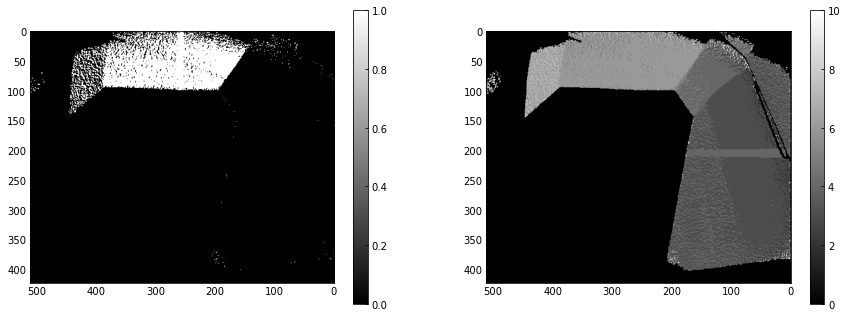

[ 0  2  3  4  5  6  7  8  9 10]
11025
5195
17091
2303
[0 1 2 3 4]


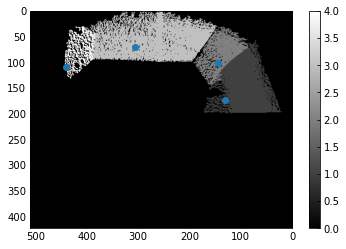

In [78]:
xyz_back_mean = postBase.convDepth2XYZ(mt, ds_back_mean)
nv_mean = postBase.calcNormal(xyz_back_mean)

arctan_mean = postBase.calcArctan(nv_mean) + 22.5*np.pi/180.0
arctan_mean = postBase.calcMinMaxScaling(arctan_mean, 10).astype('uint8')
np.set_printoptions(threshold=np.inf)
fig, ax = plt.subplots(1,2, figsize=(15, 9))
arctan_test = np.where(arctan_mean==6, 1, 0)
ax0 = ax[0].imshow(arctan_test, cmap="gray")
ax1 = ax[1].imshow(arctan_mean, cmap='gray')
ax[0].invert_xaxis()
ax[1].invert_xaxis()
fig.colorbar(ax0, ax=ax[0], shrink=0.6)
fig.colorbar(ax1, ax=ax[1], shrink=0.6)
plt.show()

seedList = [
      [3, 131, 174]
    , [4, 145, 101]
    , [6, 306, 69]
    , [7, 441, 109]
]

h, w = arctan_mean.shape[:2]
mask0 = np.zeros((h + 2, w + 2), dtype='uint8')
mask0[1:-1,1:-1] = arctan_mean
print(np.unique(mask0))
markers = np.zeros_like(arctan_mean, dtype='uint8')
for n, [val, i, j] in enumerate(seedList):
    mask = np.where(mask0 == val, 0, 1).astype('uint8')
    #markers:塗りつぶされた後の画像．なおここではmarkers配列に対してseed値で渡された値の領域を蓄積している
    #mask:塗りつぶしのみの画像
    retval, markers, mask, rect = cv2.floodFill(
        markers, mask, seedPoint=(i, j), newVal=n+1,
        loDiff=100,
        upDiff=100,
        flags=cv2.FLOODFILL_FIXED_RANGE)
    print(retval)
print(np.unique(markers))


fig, ax = plt.subplots()
ax1 = plt.imshow(markers, cmap='gray')
plt.scatter([s[1] for s in seedList], [s[2] for s in seedList])
ax.invert_xaxis()
plt.colorbar(ax1)
plt.show()

In [79]:
param_plane = []
vec_plane = []
xyz_plane = []
plane_errors = []
for n, [val, i, j] in enumerate(seedList):
    d = np.where(markers == n+1, ds_back_mean, 0)
    #非ゼロの要素の大きさを取得
    count = d[d.nonzero()].size
    print(f"position {i, j}")
    print('%d : count=%d' % (n, count))
    if count == 0:
        param_plane.append([])
        vec_plane.append([])
        xyz_plane.append([])
        continue
    #print(d[d.nonzero()])
    #base.writeXYZ(dirName0+'/plane_%02d.xyz' % (n), d, mapperTable)
    xyz = postBase.convDepth2XYZ(mt, d)
    xyz = xyz[xyz.nonzero()]
    xyz = xyz.reshape(xyz.size//3, 3)
    vec_normal, param = postBase.calcPlane(xyz, showFlag=False)
    error = calc_plane_distance(xyz, param)
    plane_errors.append([n, np.sum(error)])
    param_plane.append(param)
    vec_plane.append(vec_normal)
    xyz_plane.append(xyz)

position (131, 174)
0 : count=11025
mean=7.218212e-17, std=0.256058, count=11025
[ 0.77368348  0.39561882 -0.49487334  4.83526509]
mean=-1.581004e-10, std=0.120543, count=8150
[ 0.73854362  0.41230605 -0.53343889  4.94115883]
mean=1.096131e-15, std=0.064036, count=5578
[ 0.72742345  0.41912156 -0.54331596  4.95696306]
mean=-3.726845e-12, std=0.035260, count=3467
[ 0.72333951  0.42263137 -0.54604275  4.95609256]
position (145, 101)
1 : count=5195
mean=-3.501423e-16, std=0.185916, count=5195
[-0.50211065  0.41868625  0.7566946  -7.58182293]
mean=-2.407170e-15, std=0.102524, count=3489
[-0.49609464  0.43090319  0.75379874 -7.56885893]
mean=2.037885e-17, std=0.056534, count=2092
[-0.49418303  0.43442211  0.75303423 -7.56444449]
mean=-1.118920e-15, std=0.031448, count=1251
[-0.49380352  0.43435103  0.75332414 -7.5643648 ]
position (306, 69)
2 : count=17091
mean=-9.915420e-17, std=0.066029, count=17091
[ 5.53095346e-03  8.24910137e-01  5.65236831e-01 -6.44866490e+00]
mean=7.612950e-10, std=0

In [80]:
print(plane_errors)
total = 0
for value in plane_errors:
    total += value[1]
print(total)

[[0, 856.2274210945183], [1, 326.85634033502623], [2, 682.7354863617695], [3, 23.54404180318115]]
1889.3632895944952


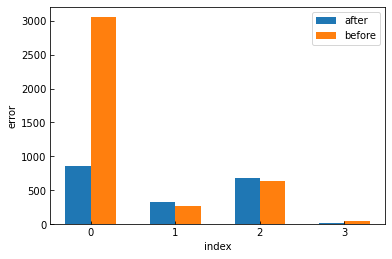

In [90]:
errors = [int(value) for [index, value] in plane_errors]
errors_defalut = [int(value) for [index, value] in plane_error_defalut]
index_lis = [index for [index, value] in plane_errors]
plt.bar(index_lis, errors, width=-0.3, align="edge", label="after")
plt.bar(index_lis, errors_defalut, width=0.3, align="edge", label="before")
plt.xticks(index_lis, index_lis)
plt.xlabel("index")
plt.ylabel("error")
plt.legend();

### 各平面の法線ベクトル，隣り合う2平面の交線ベクトルの算出

In [26]:
vec_intersection = []
pos_intersection = []
param_intersection = []
for n in range(len(seedList)-1):
    vec, pos, param = postBase.calcIntersection(param_plane[n], param_plane[n+1])
    vec_intersection.append(vec)
    pos_intersection.append(pos)
    param_intersection.append(param)

print('### plane normal vector ###')
for n, vec in enumerate(vec_plane):
    print(n, vec)
print('### intersection vector ###')
for n, vec in enumerate(vec_intersection):
    print(n, vec)


### plane normal vector ###
0 [ 0.77368348  0.39561882 -0.49487334]
1 [-0.50211065  0.41868625  0.7566946 ]
2 [0.00553095 0.82491014 0.56523683]
3 [0.64770147 0.746733   0.15123699]
### intersection vector ###
0 [ 0.63160745 -0.42014242  0.65157684]
1 [ 0.6077605  -0.45164195  0.653182  ]
2 [ 0.41926654 -0.51507687  0.74760377]


### 算出したベクトルから変換行列を算出

In [27]:
# xvec = 0.5*(vec_intersection[0] + vec_intersection[3])
xvec = 0.5*(vec_intersection[0] + vec_intersection[2])
yvec1 = np.cross(xvec, vec_plane[2])
xvec = 0.5*(vec_intersection[1] + vec_intersection[2])
yvec2 = np.cross(xvec, vec_plane[2])
yvec = 0.5*(yvec1 + yvec2)
norm = np.linalg.norm(yvec)
yvec /= norm

zvec = vec_plane[2]
zvec = zvec - np.dot(zvec, yvec)*yvec
zvec = np.dot(postBase.rotation_mat(-2.6, yvec), zvec)
norm = np.linalg.norm(zvec)
zvec /= norm

xvec = np.cross(zvec, yvec)
norm = np.linalg.norm(xvec)
xvec /= norm

print('Vec Ave (X-axis) : ', xvec)
print('SideVec (Y-axis) : ', yvec)
print('VertVec (Z-axis) : ', zvec)

M = np.array([xvec, yvec, zvec])
inv_M = np.linalg.inv(M.T)
print('Transformation Matrix : ')
print(inv_M)
print('Transformation Matrix Check : ')
print(np.dot(inv_M, xvec.T))
print(np.dot(inv_M, yvec.T))
print(np.dot(inv_M, zvec.T))

transM = inv_M

Vec Ave (X-axis) :  [ 0.52235523 -0.5210332   0.6750329 ]
SideVec (Y-axis) :  [-0.85222595 -0.29182125  0.43422494]
VertVec (Z-axis) :  [0.02925667 0.80210022 0.59647237]
Transformation Matrix : 
[[ 0.52235523 -0.5210332   0.6750329 ]
 [-0.85222595 -0.29182125  0.43422494]
 [ 0.02925667  0.80210022  0.59647237]]
Transformation Matrix Check : 
[1.00000000e+00 0.00000000e+00 1.11022302e-16]
[-5.55111512e-17  1.00000000e+00  0.00000000e+00]
[-5.55111512e-17 -5.55111512e-17  1.00000000e+00]


In [28]:
print(vec_intersection)

[array([ 0.63160745, -0.42014242,  0.65157684]), array([ 0.6077605 , -0.45164195,  0.653182  ]), array([ 0.41926654, -0.51507687,  0.74760377])]


### XYZを変換行列で座標変換して描画

In [29]:
depths = {}
depths['ds_BF_front'] = ds_BF_front
depths['ds_BF'] = ds_BF
depths['ds_front'] = ds_front
depths['ds'] = ds[2]
depths['ds_back'] = ds_back[2]

@widgets.interact(key=depths.keys(), nFrame=(0, ds[0]-1, 1))
def showXYZ(key, nFrame):
    xyz0s = postBase.convDepth2XYZ(mt, depths[key][nFrame])
    xyz0s = [xyz for xyz in xyz0s.reshape((-1,3)) if xyz[2] != 0]
    xyz0s = np.array(xyz0s, dtype='float32')
    
    xyz1s = postBase.convXYZbyMat(xyz0s, transM)
    
    point_cloud = pv.PolyData(xyz1s)
    display(point_cloud)

    pl = pv.PlotterITK()
    pl.add_mesh(point_cloud, scalars=np.array(xyz1s[:,2]), smooth_shading=True)
    #pl.add_mesh(point_cloud)
    pl.show(True)

interactive(children=(Dropdown(description='key', options=('ds_BF_front', 'ds_BF', 'ds_front', 'ds', 'ds_back'…

### YZ面上に点群を描画

In [30]:
def isInCircle(xyz, r, c):
    dxyz = np.abs(xyz - c)
    return dxyz[1] < r[1] and dxyz[2] < r[2]

def extractObject(depths):
    xyz0s = postBase.convDepth2XYZ(mt, depths)
    xyz0s = [xyz for xyz in xyz0s.reshape((-1,3)) if xyz[2] != 0]
    xyz0s = np.array(xyz0s, dtype='float32')
    #print(0)
    
    xyz1s = postBase.convXYZbyMat(xyz0s, transM)
    #print(1)
    
    xyz2s = [xyz for xyz in xyz1s if 4.0 < xyz[0] and xyz[0] < 8]
    xyz2s = np.array(xyz2s, dtype='float32')
    #print(2)
    
    xyz_mean = np.mean(xyz2s, axis=0)
    xyz_std = np.std(xyz2s, axis=0)
    #print(3.0)
    
    xyz3s = [xyz for xyz in xyz2s if isInCircle(xyz, xyz_std*2, xyz_mean)]
    xyz3s = np.array(xyz3s, dtype='float32')
    #print(3.1)

    #xyz_mean = np.mean(xyz3s, axis=0)
    #xyz_std = np.std(xyz3s, axis=0)
    #xyz4s = [xyz for xyz in xyz3s if isInCircle(xyz, xyz_std*3, xyz_mean)]
    #xyz4s = np.array(xyz4s, dtype='float32')

    return [xyz3s, xyz_mean, xyz_std]

In [31]:
@widgets.interact(key=depths.keys(), nFrame=(0, ds[0]-1, 1))
def showXYZ(key, nFrame):
    xyz3s, xyz_mean, xyz_std = extractObject(depths[key][nFrame])
    print(xyz_mean)
    print(xyz_std)
    
    point_cloud = pv.PolyData(xyz3s)
    display(point_cloud)

    pl = pv.PlotterITK()
    pl.add_mesh(point_cloud, scalars=np.array(xyz3s[:,2]), smooth_shading=True)
    #pl.add_mesh(point_cloud)
    pl.show(True)

interactive(children=(Dropdown(description='key', options=('ds_BF_front', 'ds_BF', 'ds_front', 'ds', 'ds_back'…

area :  7130.185546875
radius : 47.64040879227518


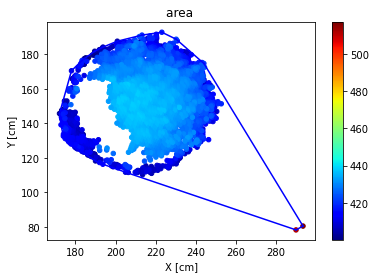

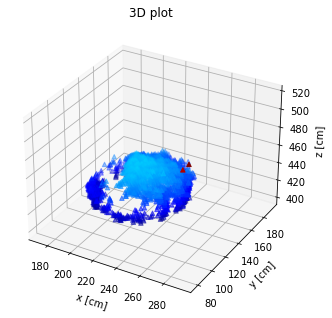

In [32]:
#myfix
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d import Axes3D

nframe = 116
xyz3s, _, _ = extractObject(depths["ds_BF_front"][nframe])
x = xyz3s[:,2] * 100
y = xyz3s[:,1] * 100
z = xyz3s[:,0] * 100


# ax = Axes3D(fig)

# #軸にラベルを付けたいときは書く
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")


#最後に.show()を書いてグラフ表示
# plt.show()


def polygon_area(x, y):
    return abs(sum(x[i]*y[i-1] - y[i]*x[i-1] for i in range(len(x)))) / 2

def calc_center_area(X, Y):
    array = []
    for x, y in zip(X, Y):
        array.append([x,y])
    array = np.array(array)
    hull = ConvexHull(array)
    x, y = [], []
    # simplex:array配列の結合部分のindex番号
    for simplex, vertice in zip(hull.simplices, hull.vertices):
        x.append(array[vertice][0])
        y.append(array[vertice][1])
    center_x, center_y = sum(x) / len(x), sum(y) / len(y)
    area = polygon_area(x, y)
    return center_x, center_y, area

def create_convex_map(X, Y, Z):
    array = []
    fig = plt.figure()
    ax = fig.add_subplot()
    for x, y in zip(X, Y):
        array.append([x,y])
    array = np.array(array)
    hull = ConvexHull(array)
    im = ax.scatter(X, Y, c=Z, label="key points", cmap="jet", s=20)
    ax.set_xlabel("X [cm]")
    ax.set_ylabel("Y [cm]")
    ax.set_title("area ")
    #外周部分の座標配列
    x, y, countors = [], [], []
    # simplex:array配列の結合部分のindex番号
    for simplex, vertice in zip(hull.simplices, hull.vertices):
        countors.append([array[vertice][0], array[vertice][1]])
        x.append(array[vertice][0])
        y.append(array[vertice][1])
        ax.plot(array[simplex, 0], array[simplex, 1], c="blue")
    center_x, center_y = sum(x) / len(x), sum(y) / len(y)
#     ax.scatter(center_x, center_y, c="purple")
    area = polygon_area(x, y)
    radius = (area / np.pi) ** (0.5)
    print("area : ", polygon_area(x, y))
    print(f"radius : {radius}")   
    plt.colorbar(im,aspect=20, ax=ax)

create_convex_map(x, y, z)
fig = plt.figure()
ax = Axes3D(fig)
ax.set_title("3D plot")
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")
ax.set_zlabel("z [cm]")

ax.scatter(x, y, z, c=z, marker="^", cmap="jet");#Kinect

In [33]:
def clip_noise(x, y, z, center_x, center_y):
    xyz = np.array([[xi, yi, zi] for xi, yi, zi in zip(x, y, z)])
    delete_idx = list(*np.where(abs(xyz[:, 0] - center_x) >= 51))
    delete_idy = list(*np.where(abs(xyz[:, 1] - center_y) >= 51))
    delete_index = list(set([*delete_idx, *delete_idy]))
    xyz = np.delete(xyz, delete_index, 0)
    return xyz[:,0], xyz[:,1], xyz[:,2]

@widgets.interact(key=depths.keys(), nFrame=(0, ds[0]-1, 1))
def showXYZ(key, nFrame):
    xyz3s, xyz_mean, xyz_std = extractObject(depths[key][nFrame])
    x = xyz3s[:,2] * 100
    y = xyz3s[:,1] * 100
    z = xyz3s[:,0] * 100
    center_x, center_y, area = calc_center_area(x, y)
    x, y, z = clip_noise(x, y, z, center_x, center_y)

    print(xyz_mean)
    print(xyz_std)
    
    create_convex_map(x, y, z)

interactive(children=(Dropdown(description='key', options=('ds_BF_front', 'ds_BF', 'ds_front', 'ds', 'ds_back'…

In [34]:
@widgets.interact(key=depths.keys(), nFrame=(0, ds[0]-1, 1))
def showXYZ(key, nFrame):
    xyz3s, xyz_mean, xyz_std = extractObject(depths[key][nFrame])
    print(xyz_mean)
    print(xyz_std)
    
    center, radius = postCore.minEnclosingCircle(xyz3s)
    print(f"center: {center}, radius: {radius}")
    
    plt.scatter(xyz3s[:,1], xyz3s[:,2], c=xyz3s[:,0], cmap='rainbow')
    plt.colorbar()
    
    ts = np.linspace(0, 2*np.pi, 50)
    x_circle = 3*xyz_std[1]*np.cos(ts) + xyz_mean[1]
    y_circle = 3*xyz_std[2]*np.sin(ts) + xyz_mean[2]
    plt.plot(x_circle, y_circle)
    
    x_circle = radius*np.cos(ts) + center[0]
    y_circle = radius*np.sin(ts) + center[1]
    plt.plot(x_circle, y_circle)
    
    plt.show()

interactive(children=(Dropdown(description='key', options=('ds_BF_front', 'ds_BF', 'ds_front', 'ds', 'ds_back'…

### 凸包による形状の算出

In [35]:
def clip_noise(x, y, z, center_x, center_y):
    xyz = np.array([[xi, yi, zi] for xi, yi, zi in zip(x, y, z)])
    delete_idx = list(*np.where(abs(xyz[:, 0] - center_x) >= 51))
    delete_idy = list(*np.where(abs(xyz[:, 1] - center_y) >= 51))
    delete_index = list(set([*delete_idx, *delete_idy]))
    xyz = np.delete(xyz, delete_index, 0)
    return xyz[:,0], xyz[:,1], xyz[:,2]
x_lis, y_lis, z_lis = [], [], [] 
cs = []
rs = []
areas = []
for i, d in enumerate(ds_BF_front):
    xyz3s, xyz_mean, xyz_std = extractObject(d)
    x = xyz3s[:,2] * 100
    y = xyz3s[:,1] * 100
    z = xyz3s[:,0] * 100
   
    #外接円を使用する場合は下
#     center, radius = postCore.minEnclosingCircle(xyz3s * 100)
    center_x, center_y, area = calc_center_area(x, y)
    x, y, z = clip_noise(x, y, z, center_x, center_y)
    x_lis.append(x)
    y_lis.append(y)
    z_lis.append(z)
    center_x, center_y, area = calc_center_area(x, y)
    radius = (area / np.pi) ** (0.5)
    print(f"{i} ({center_x:.2f}, {center_y:.2f}) {area:.2f} {radius:.2f}")
    cs.append((center_x, center_y))
    rs.append(radius)
    areas.append(area)

0 (228.84, 166.88) 4792.07 39.06
1 (224.56, 174.95) 4944.03 39.67
2 (225.18, 163.71) 4848.29 39.28
3 (220.89, 162.87) 4902.59 39.50
4 (218.78, 159.61) 4765.44 38.95
5 (217.69, 158.37) 4839.44 39.25
6 (210.01, 156.49) 4846.78 39.28
7 (213.59, 153.03) 4910.87 39.54
8 (209.81, 149.57) 4866.99 39.36
9 (211.41, 151.63) 4787.68 39.04
10 (203.63, 146.22) 4863.91 39.35
11 (204.34, 146.34) 4998.42 39.89
12 (206.92, 142.24) 5015.49 39.96
13 (208.20, 148.14) 4893.13 39.47
14 (208.45, 143.40) 4965.40 39.76
15 (207.77, 149.89) 4964.28 39.75
16 (209.58, 146.20) 4952.82 39.71
17 (211.07, 149.27) 4905.59 39.52
18 (214.49, 146.04) 4803.81 39.10
19 (214.45, 145.21) 4879.50 39.41
20 (213.18, 144.40) 4920.27 39.57
21 (224.01, 147.81) 4900.63 39.50
22 (217.37, 148.76) 4909.54 39.53
23 (222.48, 148.09) 4974.01 39.79
24 (221.17, 144.14) 4782.55 39.02
25 (224.91, 151.90) 4957.49 39.72
26 (227.53, 151.40) 5033.46 40.03
27 (218.71, 149.46) 4955.50 39.72
28 (221.91, 143.95) 4922.31 39.58
29 (221.77, 143.38) 4834

In [36]:
np.set_printoptions(threshold=np.inf)
with open("records_left.txt", "w") as f:
    f.write("frame center_x center_y radius area \n")
    for i, (center, radius, area) in enumerate(zip(cs, rs, areas)):
        f.write(f"{i+1} {center[0]} {center[1]} {radius} {area} \n")
np.set_printoptions(threshold=0)

4872.734609375


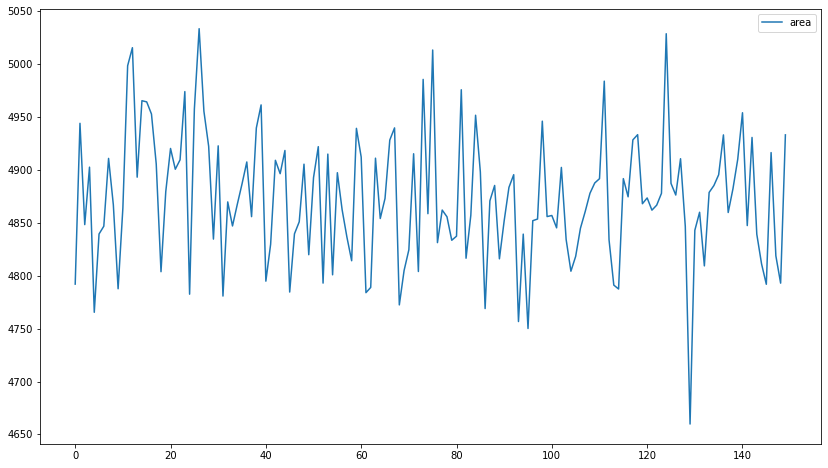

In [37]:
print(sum(areas) / len(areas))
frames = range(len(ds[1]))
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(frames, areas, label="area");
plt.legend();

39.38245080096935 [214.93771821 145.55958494]
0.24933476131963214 [9.87263867 8.55222616]


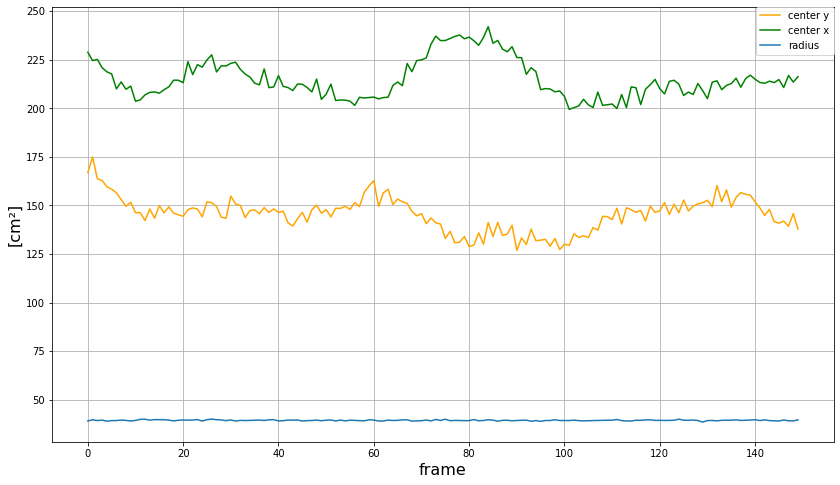

In [38]:
rs = np.array(rs)
cs = np.array(cs)
areas = np.array(areas)
print(rs.mean(), cs.mean(axis=0))
print(rs.std(), cs.std(axis=0))

frames = range(len(ds[1]))
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.plot(frames, cs[:,1], label='center y', c="orange")
ax.plot(frames, cs[:,0], label='center x', c="green")
ax.plot(frames, rs, label='radius')
ax.set_xlabel('frame', fontsize=16)
ax.set_ylabel('[cm²]', fontsize=16)
plt.legend(bbox_to_anchor=(1,1), loc='upper right', borderaxespad=0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid()
plt.show()


## 外接円

In [ ]:
cs = []
rs = []
areas = []
for i, d in enumerate(ds_BF_front):
    xyz3s, xyz_mean, xyz_std = extractObject(d)
    x = xyz3s[:,2] * 100
    y = xyz3s[:,1] * 100
   
    #外接円を使用する場合は下
    center, radius = postCore.minEnclosingCircle(xyz3s * 100)
#     center_x, center_y, area = calc_center_area(x, y)
    area = np.pi * radius ** 2 
    print(i, center, radius, area)
    cs.append(center)
    rs.append(radius)
    areas.append(area)

In [ ]:
print(sum(areas) / len(areas))

In [ ]:
rs = np.array(rs)
cs = np.array(cs)
print(rs.mean(), cs.mean(axis=0))
print(rs.std(), cs.std(axis=0))

frames = range(len(ds[1]))
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.plot(frames, cs[:,1], label='center y', c="orange")
ax.plot(frames, cs[:,0], label='center x', c="green")
ax.plot(frames, rs, label='radius')
ax.set_xlabel('frame', fontsize=16)
ax.set_ylabel('[cm²]', fontsize=16)
plt.legend(bbox_to_anchor=(1,1), loc='upper right', borderaxespad=0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid()
plt.show()
